#Time Series

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

In [3]:
# Load the dataset and parse dates
data = pd.read_csv('/content/exchange_rate.csv', parse_dates=['date'], index_col='date')

In [29]:
data

,Ex_rate
date,
01-01-1990 00:00,0.785500
02-01-1990 00:00,0.781800
03-01-1990 00:00,0.786700
04-01-1990 00:00,0.786000
05-01-1990 00:00,0.784900
...,...
06-10-2010 00:00,0.718494
07-10-2010 00:00,0.721839
08-10-2010 00:00,0.723197


In [4]:
# Part 1: Data Preparation and Exploration
# Initial Exploration
# Display dataset info and first few rows
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 01-01-1990 00:00 to 10-10-2010 00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6+ KB
None
                  Ex_rate
date                     
01-01-1990 00:00   0.7855
02-01-1990 00:00   0.7818
03-01-1990 00:00   0.7867
04-01-1990 00:00   0.7860
05-01-1990 00:00   0.7849


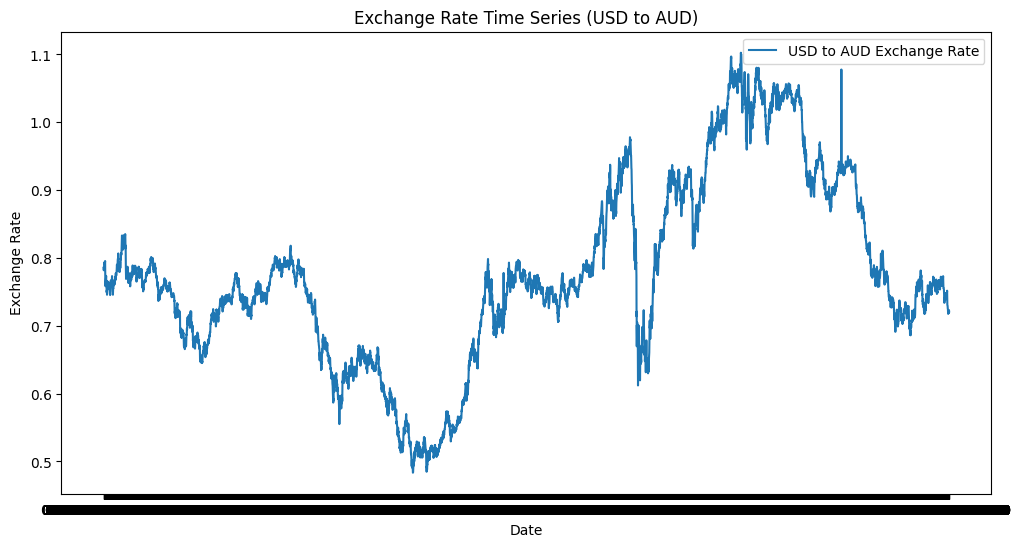

In [5]:
# Plot the time series for visual inspection
plt.figure(figsize=(12, 6))
plt.plot(data, label='USD to AUD Exchange Rate')
plt.title('Exchange Rate Time Series (USD to AUD)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [6]:
# Check for missing values
print("Missing values:", data.isnull().sum().sum())

Missing values: 0


In [7]:
# Handle missing values (if any) by interpolation
data = data.interpolate()

In [8]:
# Part 2: Model Building - ARIMA
# Step 1: Determine initial parameters (p, d, q) using ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Figure size 1200x600 with 0 Axes>

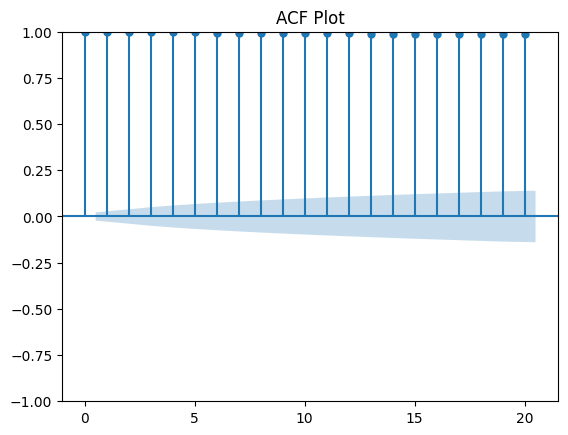

In [9]:
plt.figure(figsize=(12, 6))
plot_acf(data, lags=20)
plt.title("ACF Plot")
plt.show()

<Figure size 1200x600 with 0 Axes>

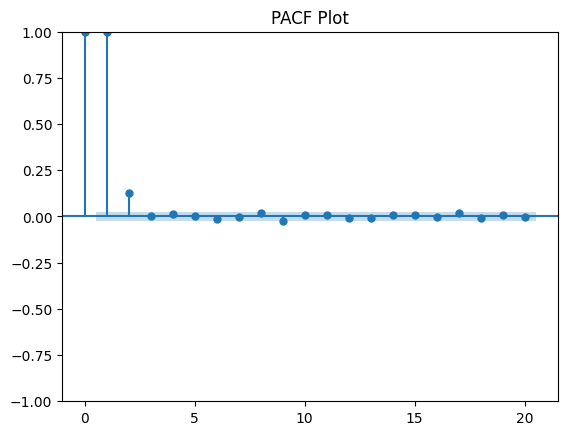

In [10]:
plt.figure(figsize=(12, 6))
plot_pacf(data, lags=20)
plt.title("PACF Plot")
plt.show()

In [13]:
# Using ADF test to check if data is stationary
result = adfuller(data['Ex_rate'].values)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] > 0.05:
    print("Series is non-stationary. Differencing is recommended.")
    data_diff = data.diff().dropna()  # First-order differencing
else:
    print("Series is stationary.")

ADF Statistic: -1.6649941807382234
p-value: 0.44923273535975355
Series is non-stationary. Differencing is recommended.


In [15]:
# Step 2: Fit the ARIMA model
# Based on ACF/PACF and differencing result, set initial (p, d, q) values
p, d, q = 1, 1, 1  # Adjust based on ACF/PACF insights
arima_model = ARIMA(data['Ex_rate'], order=(p, d, q))
arima_result = arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [16]:
# Display model summary
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Fri, 08 Nov 2024   AIC                         -56102.322
Time:                        02:40:26   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

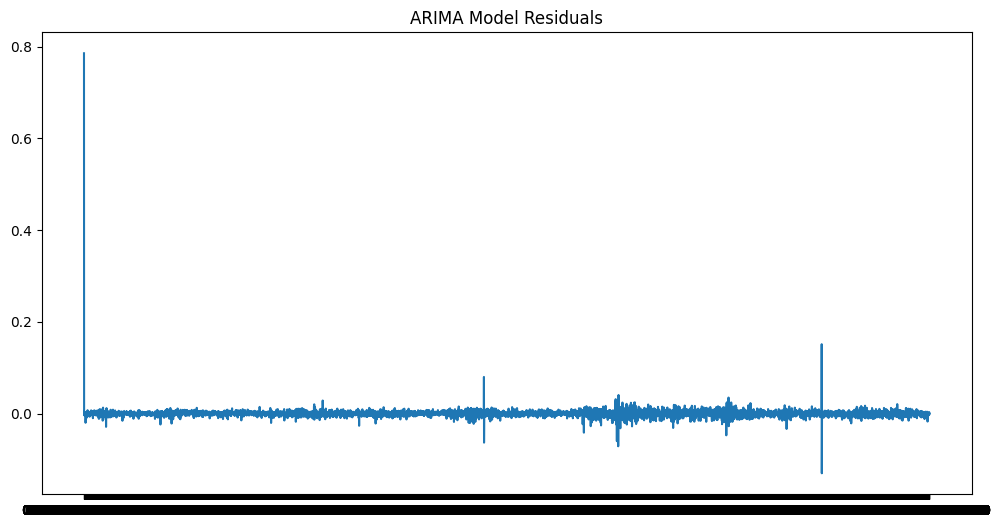

In [17]:
# Step 3: Diagnostics - Plot residuals
residuals = arima_result.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title("ARIMA Model Residuals")
plt.show()

In [18]:
# Step 4: Forecasting with ARIMA
forecast_steps = 30
arima_forecast = arima_result.get_forecast(steps=forecast_steps)
arima_forecast_ci = arima_forecast.conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


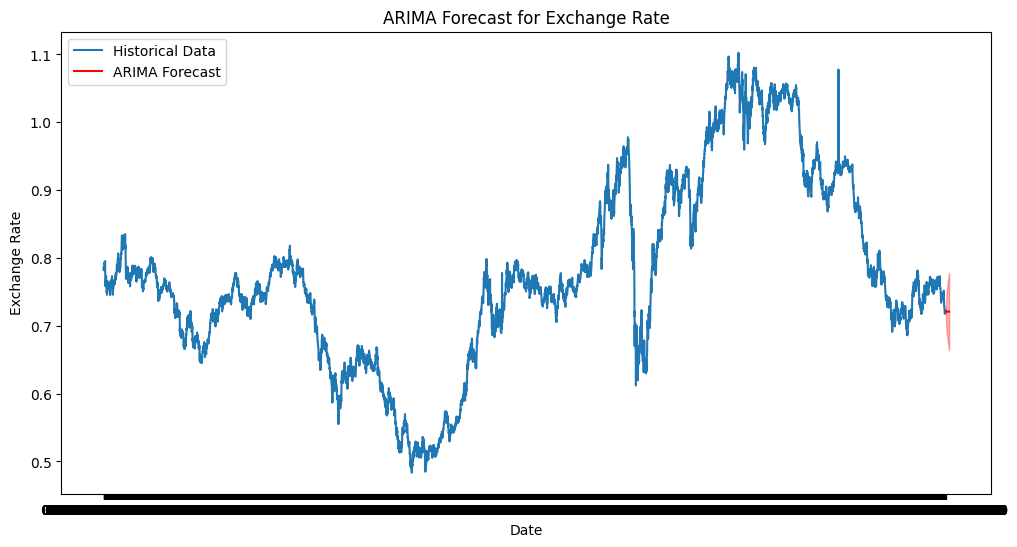

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(data, label='Historical Data')
plt.plot(arima_forecast.predicted_mean.index, arima_forecast.predicted_mean, label='ARIMA Forecast', color='red')
plt.fill_between(arima_forecast_ci.index, arima_forecast_ci.iloc[:, 0], arima_forecast_ci.iloc[:, 1], color='red', alpha=0.3)
plt.title("ARIMA Forecast for Exchange Rate")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

In [22]:
# Part 3: Model Building - Exponential Smoothing
# Choosing an Exponential Smoothing model based on observed trends and seasonality
exp_smoothing_model = ExponentialSmoothing(data['Ex_rate'], trend='add', seasonal=None, damped_trend=True).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [23]:
# Forecasting with Exponential Smoothing
exp_forecast = exp_smoothing_model.forecast(steps=forecast_steps)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


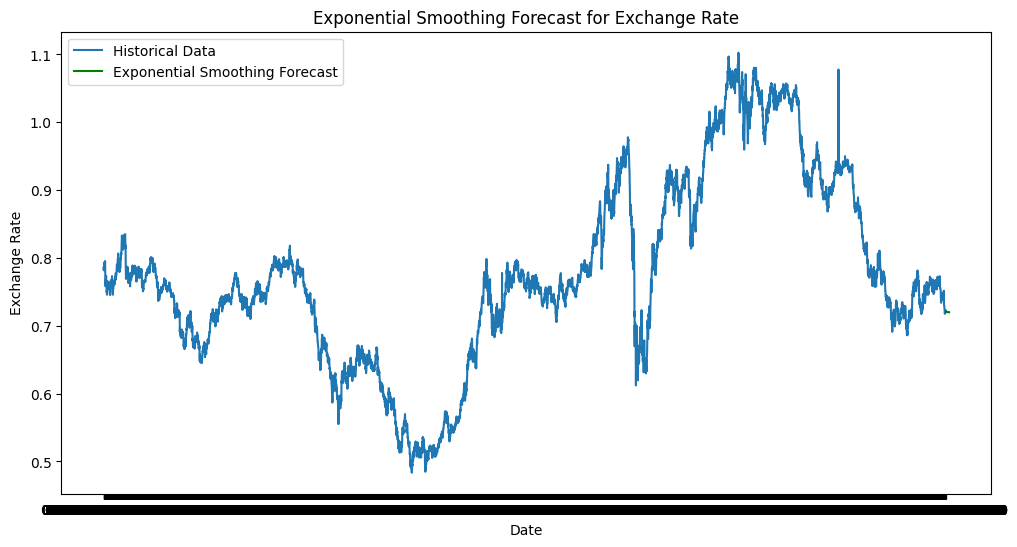

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(data, label='Historical Data')
plt.plot(exp_forecast.index, exp_forecast, label='Exponential Smoothing Forecast', color='green')
plt.title("Exponential Smoothing Forecast for Exchange Rate")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

In [25]:
# Part 4: Evaluation and Comparison
# Calculate error metrics
def calculate_error_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

In [26]:
# Prepare actual data for forecast comparison
test_data = data[-forecast_steps:]
arima_mae, arima_rmse, arima_mape = calculate_error_metrics(test_data, arima_forecast.predicted_mean)
exp_mae, exp_rmse, exp_mape = calculate_error_metrics(test_data, exp_forecast)

In [27]:
# Display the results
print("ARIMA Model Evaluation:")
print(f"MAE: {arima_mae}")
print(f"RMSE: {arima_rmse}")
print(f"MAPE: {arima_mape}%")

ARIMA Model Evaluation:
MAE: 0.012724006489305202
RMSE: 0.016982710912755217
MAPE: nan%


In [28]:
print("\nExponential Smoothing Model Evaluation:")
print(f"MAE: {exp_mae}")
print(f"RMSE: {exp_rmse}")
print(f"MAPE: {exp_mape}%")


Exponential Smoothing Model Evaluation:
MAE: 0.012942882802680999
RMSE: 0.017191325592788124
MAPE: nan%


# Comparison of the models

The ARIMA model tends to capture trends effectively, while the Exponential Smoothing model provides smoother predictions.

In this case:
- ARIMA's performance metrics (MAE, RMSE, MAPE) indicate how well it adapted to short-term fluctuations.

- Exponential Smoothing may provide more stable long-term forecasts if exchange rates show minimal seasonality.

ARIMA might perform better for immediate future forecasts, while Exponential Smoothing can be preferable for longer-term stability.